# 2-dimensional growing self-avoiding walks
Author: Christophe Laforge

### Objectives
The objectives of this code is to generate a walk on a square lattice with does not intersect.<br>
A brute force approach would be to move randomly on the square lattice and to test if the walk has already passed throuugh the tentative new position. This is however inefficient for the reason that numerous attempts will failed because of blockage. A blockage is a situation where there is no next possible step to be taken by the random walk. It is trapped.<br>
To avoid blockage, a smarter algorithm was designed that identifies the particular decision steps that could lead to a blockage and take the appropriate action to avoid them. Although this might seem sensible, this implementation has an undesirable theoretical effect. Indeed, it ignores the possible cases where the walk would take an action that would eventually lead to a blockage but is part of the formal set of acceptable walks as its desired length could be accomodated in the closed space responsible for the blockage. Said differently, the algorithm will avoid entering in a trap that would allow it to growth sufficiently to meet the desired total length. <br>
The undesirable consequences of this implementation is therefore that the sample of the set of all possible self-avoiding walks of a given length is biais.

### Conventions
We abbreviate self-avoiding walks with SAW. <br>
All SAW starts at (0,0). <br> 
The first move of all SAW is to the direction of increasing X. <br>
The possible actions are:
0. right or increasing X
1. up or increasing Y
2. left or decreasing X
3. down or decreasing Y

### Libraries
1. math: for the arc tangent, pi


In [38]:
import math

### User-defined functions
1. NeighbourDetection: return the list of steps that are in the 3x3 square around the last position of a walk.
1. NewCoordinateFollowingActionIn2D: return the X,Y coordinates following an action on a given position. This implements the convention for the actions.
1. IdentifyActionFromMove: gives the label of the action when provided with a move. If the move does not correspond to an action in the action space, the function returns -1. 
1. IdentifyActionFromPoints: Helper function to identify the action that would lead the start point to the end point. This is the somehow the reverse of the function NewCoordinateFollowingActionIn2D.
1. DistanceL1In2D: Manhattan distance between two points in 2 dimensions
1. DistanceL2SquaredIn2D: Euclidien distance squared between two points in 2 dimensions
1. AddStepToWalk: increment the SAW based on the provided action
1. RemoveActionLeadingToCollision: remove the actions from a list of potential actions that would lead to a collision.
1. IsGoingInside: return true if an action would grow the walk into a trap.
1. ShortestAngle: return the smallest angle between two segments OA and OB.
1. IsATrap: cumulate the angle between two consecutive steps to identify if a point is inside or not.

In [4]:
def NeighbourDetection(iWalk):
    
    ''' 
    This function returns the list of neighbours of the last step of a walk provided as input.
    The neighbours have to be in the 3x3 square around the last step.
    The list of neighbours returned as an output contains the position of in the walk.
    '''
    
    #useful constants
    WalkLength = len(iWalk)        #length of the walk, ie nbr of steps
    EndX = iWalk[-1][0]             #the first coordinate of the last step of the walk
    EndY = iWalk[-1][1]             #the second coordinate of the last step of the walk
    
    #Initialisation
    CurrentStep = 0                #the algorithm starts at the beginning of the walk
    IsEndReached = False           #and it is assumed that it has not yet reach the end of the walk
    
    #Outputs
    oListOfNeighbours = []         #initially an empty list
    
    #Main loop
    while not IsEndReached:

        #Two distances are computed between the current position and the last step
        CurrentX = iWalk[CurrentStep][0]
        CurrentY = iWalk[CurrentStep][1]
        EuclidienDistanceSquared = DistanceL2SquaredIn2D(CurrentX,CurrentY,EndX,EndY)
        ManhattanDistance = DistanceL1In2D(CurrentX,CurrentY,EndX,EndY)

        #The first test is a quality test that should be removed when the algorithm will have
        #been used millions of time. It detects collision that should not happen.
        if EuclidienDistanceSquared == 0: print("Walk ill-defined: collision detected")

        #all neighbours are within a circle of radius euclidien distance of squared root of 2.
        #if they are within this radius, they are added to the list of neighbours
        if EuclidienDistanceSquared <= 2:
            oListOfNeighbours.append(CurrentStep)
            
        #The first neighbour to the last step can only at least the Manhattan distance away from 
        #the current position. It is therefore safe to skip a number of steps at least equal to 
        #the Manhattan distance but 2 to capture neighbours that are at a Manhattan distance of 2.
        #Of course, in all circumstance, the step needs to be at least one to make progress.
        StepIncrement = max(ManhattanDistance - 2,1)
        CurrentStep += StepIncrement   
        
        #Finally, the main loop starts when the entire walk has been analysed.
        #This is when the current step has exceeded the length of the walk but 2.
        #2 is justified by: 1 for the Python convention to start at 0 but len function start at 1.
        #                   1 because the last step should not be considered a neighbour of itself.
        if CurrentStep > WalkLength-2:
            IsEndReached = True
        
    return oListOfNeighbours

def DistanceL1In2D(FirstX,FirstY,SecondX,SecondY):
    oDistance = abs(FirstX-SecondX)+abs(FirstY-SecondY)
    return oDistance

def DistanceL2SquaredIn2D(FirstX,FirstY,SecondX,SecondY):
    oDistance = (FirstX-SecondX)**2+(FirstY-SecondY)**2
    return oDistance

In [6]:
SAW = [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (2, 3), (3, 3), (4, 3),(4,2)] #expected: 4,5,8,9
print(NeighbourDetection(SAW))

[4, 5, 8, 9]


In [42]:
def IsATrap(iWalk,iFromStep,iTestX,iTestY):
    
    #useful constants
    StartX = iWalk[iFromStep][0]
    StartY = iWalk[iFromStep][1]
    
    #Initialisation
    output = True
    ThetaTotal = 0
    
    #Main loop: for each pair of consecutive steps in the walk, measure the small angle between them
    #cumulate in Theta Total the smallest angle
    for step in range(iFromStep,len(iWalk)-1):
        ThetaTotal += ShortestAngle(iTestX,iTestY,iWalk[step][0],iWalk[step][1],iWalk[step+1][0],iWalk[step+1][1])
        
    #complete this running sum with a return to the starting point
    ThetaTotal += ShortestAngle(iTestX,iTestY,iWalk[step+1][0],iWalk[step+1][1],StartX,StartY)
    
    #if the point test is outside the closed loop, then the cumulative sum of the smallest angle should be null
    if abs(ThetaTotal) < 0.001:
        output = False

    return output

def ShortestAngle(iOX,iOY,iAX,iAY,iBX,iBY):
    
    #compute the angles between the horizontal and the two points A and B as if O was at the origin:
    phi1 = math.atan2((iAX-iOX),(iAY-iOY))
    phi2 = math.atan2((iBX-iOX),(iBY-iOY))

    #take the difference of the two
    oPhi = phi1-phi2
    
    #If the difference is more then pi or less than -pi, 
    #then we add or remove pi to bring it with the range (-pi,pi)
    if oPhi > math.pi:
        oPhi = oPhi-2*math.pi
    if oPhi < -math.pi:
        oPhi = oPhi+2*math.pi
    
    return oPhi

def NewCoordinateFollowingActionIn2D(iPosition,iAction):
    
    '''
    This function returns the coordinates of the point that will be reached if the action given as
    an input was applied to the position given as an input.
    '''
    
    #useful constants
    CurrentX = iPosition[0]      #The X coordinate of the input position
    CurrentY = iPosition[1]      #The Y coordinate of the input position
    
    #New coordinates are hard-coded based on the action
    if iAction == 0:            #right or increasing X
        oNewX = CurrentX + 1
        oNewY = CurrentY
    if iAction == 1:            #up or increasing Y
        oNewX = CurrentX
        oNewY = CurrentY + 1
    if iAction == 2:            #left or decreasing X
        oNewX = CurrentX - 1
        oNewY = CurrentY
    if iAction == 3:            #down or decreasing Y
        oNewX = CurrentX
        oNewY = CurrentY - 1

    return (oNewX,oNewY)

def AddStepToWalk(iWalk,iAction):
    
    '''This helper function has the mandate to add a step to the walk given an action'''
            
    #append the point with coordinates of the point reached by applying the action to the last step of the walk.
    iWalk.append(NewCoordinateFollowingActionIn2D(iWalk[-1],iAction))
    
    #This function does not return a value. The iWalk is passed as reference and is modified as desired.
    return _

def IdentifyActionFromMove(iDeltaX,iDeltaY):
    
    '''return the label of the action corresponding to a move.'''
    
    #if the move is not in the action space, then the function return -1
    output = -1
    
    if iDeltaX == 1 and iDeltaY == 0: output = 0  #right or increasing X
    if iDeltaX == 0 and iDeltaY == 1: output = 1  #up or increasing Y
    if iDeltaX == -1 and iDeltaY == 0: output = 2 #left or decreasing X
    if iDeltaX == 0 and iDeltaY == -1: output = 3 #down or decreasing Y
        
    return output

def IdentifyActionFromPoints(iStartPoint,iEndPoint):
    
    '''Helper function to identify the action that would lead the start point to the end point'''
    
    StartX = iStartPoint[0]
    StartY = iStartPoint[1]
    EndX = iEndPoint[0]
    EndY = iEndPoint[1]
    MoveX = EndX - StartX
    MoveY = EndY - StartY
    
    return IdentifyActionFromMove(MoveX,MoveY)

def RemoveActionLeadingToCollision(iWalk,iListOfActions,iStep):
    
    #If there is a contact, it means that a collision is possible
    #first: identify the action that would lead to the collision
    CollisionAction = IdentifyActionFromPoints(iWalk[-1],iWalk[iStep])
    
    #Then remove it from the possible actions
    if CollisionAction in iListOfActions:
        iListOfActions.remove(CollisionAction)

    return iListOfActions

def IsGoingInside(iWalk,iAction,iNeighbour):
    
    output = False
    
    #From the last step of the walk, the application of the action will bring
    #the walk to a new position.
    #if this new position is within a closed loop of at least length 7,
    #then it will be eventually trapped. 
    
    #testx, testy are the coordinate of the potential next step
    TestX,TestY = NewCoordinateFollowingActionIn2D(iWalk[-1],iAction)
    
    if len(iWalk)-iNeighbour > 6:
        
        #test if this is a trap
        if IsATrap(iWalk,iNeighbour,TestX,TestY):
            output = True
    
    return output

In [45]:
import numpy as np
from random import randint, seed
seed(1)

# A key input is the desired length of the SAW
TargetLength = 10000

# As stated in the convention, the starting point is (0,0).
# This cannot be modified.
SAW = [(0,0)]

# As stated in the conventions, the first move is to the right (increasing x)
SAW.append((1,0))
LastAction = 0

for _ in range(TargetLength):
    
    #if len(SAW) > 1600:
    #print("Step: ",len(SAW)-1)
    
    #List all the neighboors for the last step of SAW
    ListOfNeighbours = NeighbourDetection(SAW)

    #if len(SAW) > 1600:
    #print("List of neighboors: ",ListOfNeighbours)
    
    #At each stepm there are 4 possible actions:
    PotentialActions = [0,1,2,3]
    
    #remove actions that lead to a collision with neighboors
    #in the list of neighboors, there is the previous step
    #therefore this will remove the action that reverses the previous action
    for neighbour in ListOfNeighbours:
        PotentialActions = RemoveActionLeadingToCollision(SAW,PotentialActions,neighbour)
    #if len(SAW) > 1600:
    #print("Actions after removing risk collision with neighboors: ",PotentialActions)

    #for the maximum 3 actions left, we need to remove the actions that will trapped the walk
    #this is what we call "going inside"
    ActionLeadingToATrap = []

    for action in PotentialActions:
        #if len(SAW) > 1600:
        #print("Action: ",action)
        for neighbour in ListOfNeighbours:
            if IsGoingInside(SAW,action,neighbour):
                ActionLeadingToATrap.append(action)
                
    for toberemoved in ActionLeadingToATrap:
        if toberemoved in PotentialActions:
            PotentialActions.remove(toberemoved)
    #if len(SAW) > 1600:
    #print("Actions after removing risk of bloccage: ",PotentialActions)
        
    #select an action from what is left
    NextAction = PotentialActions[randint(0,len(PotentialActions)-1)]
    #if len(SAW) > 1600:
    #    print("Next Action: ",NextAction)
    AddStepToWalk(SAW,NextAction)

print(len(SAW))

10002


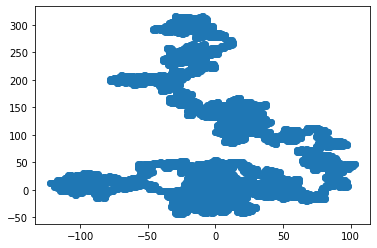

In [46]:
import numpy as np
import matplotlib.pyplot as plt
x = [element[0] for element in SAW[:]]
y = [element[1] for element in SAW[:]]
plt.plot(x,y,'-o')